<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Sequence-Processing-with-Convnets" data-toc-modified-id="Sequence-Processing-with-Convnets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sequence Processing with Convnets</a></span><ul class="toc-item"><li><span><a href="#Implementing-a-1D-convnet" data-toc-modified-id="Implementing-a-1D-convnet-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Implementing a 1D convnet</a></span></li><li><span><a href="#Combining-CNNs-and-RNNs-to-process-long-sequences" data-toc-modified-id="Combining-CNNs-and-RNNs-to-process-long-sequences-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Combining CNNs and RNNs to process long sequences</a></span></li><li><span><a href="#Wrapping-up" data-toc-modified-id="Wrapping-up-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Wrapping up</a></span></li></ul></li></ul></div>

# Sequence Processing with Convnets

1D convets can be competitive with RNNs on certain sequence-processing problems, usually at a considerably cheaper computational cost. It has long been known that small 1D convnets can offer a fast alternative to RNNs for simple tasks such as text classification and timeseries forecasting.

## Implementing a 1D convnet

In Keras, you would use a 1D convnet via the Conv1D layer, which has a very similar interface to Conv2D. It takes as input 3D tensors with shape (samples, time, features) and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal axis, axis 1 in the input tensor.

Let's build a simple 2-layer 1D convnet and apply it to the IMDB sentiment classification task that you are already familiar with.



In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)



Using TensorFlow backend.


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


1D convnets are structured in the same way as their 2D counter-parts: they consist of a stack of Conv1D and MaxPooling1D layers, eventually ending in either a global pooling layer or a Flatten layer, turning the 3D outputs into 2D outputs, allowing to add one or more Dense layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

This is our example 1D convnet for the IMDB dataset:

In [2]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [3]:
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1))

In [4]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 29s 1ms/step - loss: 0.7417 - acc: 0.5178 - val_loss: 0.6906 - val_acc: 0.5208
Epoch 2/10
20000/20000 [==============================] - 14s 700us/step - loss: 0.6718 - acc: 0.6506 - val_loss: 0.6695 - val_acc: 0.6434
Epoch 3/10
20000/20000 [==============================] - 14s 708us/step - loss: 0.6339 - acc: 0.7498 - val_loss: 0.6269 - val_acc: 0.7212
Epoch 4/10
20000/20000 [==============================] - 15s 736us/step - loss: 0.5535 - acc: 0.8075 - val_loss: 0.5220 - val_acc: 0.7752
Epoch 5/10
20000/20000 [==============================] - 14s 720us/step - loss: 0.4344 - acc: 0.8377 - val_loss: 0.4446 - val_acc: 0.8178
Epoch 6/10
20000/20000 [==============================] - 14s 711us/step - loss: 0.3581 - acc: 0.8651 - val_loss: 0.4162 - val_acc: 0.8366
Epoch 7/10
20000/20000 [==============================] - 14s 709us/step - loss: 0.3158 - acc: 0.8751 - val_loss: 0.415

Here are our training and validation results: validation accuracy is somewhat lower than that of the LSTM we used two sections ago, but runtime is faster, both on CPU and GPU (albeit the exact speedup will vary greatly depending on your exact configuration). At that point, we could re-train this model for the right number of epochs (8), and run it on the test set. This is a convincing demonstration that a 1D convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task.

In [8]:
import matplotlib.pyplot as plt 
%matplotlib inline
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(acc_values) + 1)
    
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.plot(epochs, acc_values, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc_values, 'r', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Validation')
    plt.legend()
    plt.show()

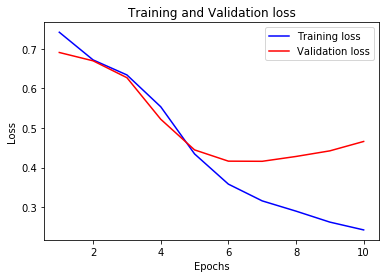

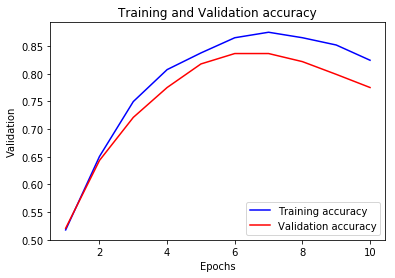

In [9]:
plot_history(history)

## Combining CNNs and RNNs to process long sequences

Because 1D convnets process input patches independently, they are not sensitive to the order of the timesteps (beyond a local scale, the size of the convolution windows), unlike RNNs. Of course, in order to be able to recognize longer-term patterns, one could stack many convolution layers and pooling layers, resulting in upper layers that would "see" long chunks of the original inputs -- but that's still a fairly weak way to induce order-sensitivity. One way to evidence this weakness is to try 1D convnets on the temperature forecasting problem from the previous section, where order-sensitivity was key to produce good predictions. Let's see:


In [10]:
import pandas as pd
import numpy as np

In [11]:
data = pd.read_csv('data/jena_climate/jena_climate_2009_2016.csv.zip')
data.head()


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [17]:
float_data = data.drop(columns='Date Time').astype('float32').values
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [18]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [19]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [21]:
#This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [22]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
300/300 [==============================] - 15s 50ms/step - loss: 0.4319 - val_loss: 0.4666
Epoch 2/10
300/300 [==============================] - 14s 46ms/step - loss: 0.3856 - val_loss: 0.4415
Epoch 3/10
300/300 [==============================] - 15s 51ms/step - loss: 0.3672 - val_loss: 0.4392
Epoch 4/10
300/300 [==============================] - 14s 48ms/step - loss: 0.3504 - val_loss: 0.4363
Epoch 5/10
300/300 [==============================] - 14s 47ms/step - loss: 0.3341 - val_loss: 0.4399
Epoch 6/10
300/300 [==============================] - 14s 46ms/step - loss: 0.3242 - val_loss: 0.4505
Epoch 7/10
300/300 [==============================] - 14s 45ms/step - loss: 0.3207 - val_loss: 0.4666
Epoch 8/10
300/300 [==============================] - 14s 46ms/step - loss: 0.3103 - val_loss: 0.4522
Epoch 9/10
300/300 [==============================] - 14s 48ms/step - loss: 0.3049 - val_loss: 0.4490
Epoch 10/10
300/300 [==============================] - 14s 47ms/step - loss: 0.299

In [23]:
def plot_mae_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

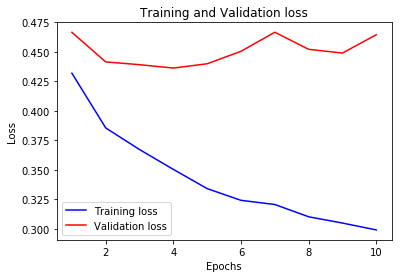

In [24]:
plot_mae_history(history)



The validation MAE stays in the low 0.40s: we cannot even beat our common-sense baseline using the small convnet. Again, this is because our convnet looks for patterns anywhere in the input timeseries, and has no knowledge of the temporal position of a pattern it sees (e.g. towards the beginning, towards the end, etc.). Since more recent datapoints should be interpreted differently from older datapoints in the case of this specific forecasting problem, the convnet fails at producing meaningful results here. This limitation of convnets was not an issue on IMDB, because patterns of keywords that are associated with a positive or a negative sentiment will be informative independently of where they are found in the input sentences.

One strategy to combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing step before a RNN. This is especially beneficial when dealing with sequences that are so long that they couldn't realistically be processed with RNNs, e.g. sequences with thousands of steps. The convnet will turn the long input sequence into much shorter (downsampled) sequences of higher-level features. This sequence of extracted features then becomes the input to the RNN part of the network.

This technique is not seen very often in research papers and practical applications, possibly because it is not very well known. It is very effective and ought to be more common. Let's try this out on the temperature forecasting dataset. Because this strategy allows us to manipulate much longer sequences, we could either look at data from further back (by increasing the lookback parameter of the data generator), or look at high-resolution timeseries (by decreasing the step parameter of the generator). Here, we will chose (somewhat arbitrarily) to use a step twice smaller, resulting in twice longer timeseries, where the weather data is being sampled at a rate of one point per 30 minutes.


In [25]:
# This was previously set to 6 (one point per hour).
# Now 3 (one point per 30 min).
step = 3
lookback = 720  # Unchanged
delay = 144 # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [27]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
300/300 [==============================] - 51s 171ms/step - loss: 0.3475 - val_loss: 0.2973
Epoch 2/10
300/300 [===============

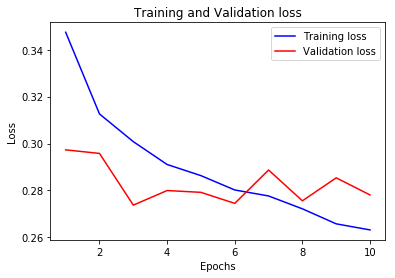

In [28]:
plot_mae_history(history)

Judging from the validation loss, this setup is not quite as good as the regularized GRU alone, but it's significantly faster. It is looking at twice more data, which in this case doesn't appear to be hugely helpful, but may be important for other datasets.
## Wrapping up

Here's what you should take away from this section:

- In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets perform well for processing temporal patterns. They offer a faster alternative to RNNs on some problems, in particular NLP tasks.
- Typically 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of Conv1D layers and MaxPooling1D layers, eventually ending in a global pooling operation or flattening operation.
- Because RNNs are extremely expensive for processing very long sequences, but 1D convnets are cheap, it can be a good idea to use a 1D convnet as a preprocessing step before a RNN, shortening the sequence and extracting useful representations for the RNN to process.

One useful and important concept that we will not cover in these pages is that of 1D convolution with dilated kernels.


In [29]:
%load_ext version_information
%version_information keras, numpy, matplotlib, pandas

Software versions
Python 3.6.4 64bit [GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
IPython 6.2.1
OS Linux 4.4.0 53 generic x86_64 with debian stretch sid
keras 2.0.9
numpy 1.12.1
matplotlib 2.1.1
pandas 0.22.0
Fri Jan 12 20:51:44 2018 CST